In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
import cvxpy as cp
import matplotlib.pyplot as plt
import ipopt

In [2]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    totalport = np.dot(cur_prices , x_init)+ cash_init
    x_optimal = x_init
    cash_optimal = cash_init
    weights = (x_optimal*cur_prices)/totalport
    return x_optimal, cash_optimal, weights

In [3]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    #compute the total asset 
    totalport = np.dot(cur_prices , x_init)+ cash_init
    #equally allocate to each stock, which is 1/20 of total asset
    alloctoW = np.ones(20) * totalport * 1/20
    
    
    x_optimal = np.floor(alloctoW/ cur_prices)
    transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005
    cash_optimal = totalport - np.dot(cur_prices, x_optimal)  - transaction
    
    #check if cash_optimal is non negative
    if cash_optimal < 0:
        #find out the ratio between the postion of each stock and total position 
        ratio = (x_optimal / sum(x_optimal))
        #allocate the negative cash to each stock to balance 
        cash_balance = np.dot(abs(cash_optimal), ratio)
        #use the allocated cash divide by stock price to get the position of each stock
        position_balance = np.ceil(cash_balance / cur_prices)
        #the new x_optimal is the difference between inital position and balanced position
        x_optimal = x_optimal - position_balance
        #recalculated transcation fee
        transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005
        #recaculate cash_optimal
        cash_optimal = totalport - np.dot(cur_prices, x_optimal) - transaction
        
    weights = (x_optimal*cur_prices)/totalport
    return x_optimal, cash_optimal, weights

In [4]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    # compute the total asset 
    totalport = np.dot(cur_prices , x_init)+ cash_init
    # 20 stocks 
    n = 20
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,0.0]])

    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0.0], senses="EG")

    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)

    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    cpx.solve()

    w_minVar = cpx.solution.get_values()[:n]
    alloctoW = np.dot(w_minVar, totalport)
    x_optimal = np.floor(alloctoW/ cur_prices) 
    transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005;
    cash_optimal = totalport - np.dot(cur_prices, x_optimal)  - transaction
    
    #check if cash_optimal is non negative
    if cash_optimal < 0:
        #find out the ratio between the postion of each stock and total position 
        ratio = (x_optimal / sum(x_optimal))
        #allocate the negative cash to each stock to balance 
        cash_balance = np.dot(abs(cash_optimal), ratio)
        #use the allocated cash divide by stock price to get the position of each stock
        position_balance = np.ceil(cash_balance / cur_prices)
        #the new x_optimal is the difference between inital position and balanced position
        x_optimal = x_optimal - position_balance
        #recalculated transcation fee
        transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005
        #recaculate cash_optimal
        cash_optimal = totalport - np.dot(cur_prices, x_optimal) - transaction
        
    weights = (x_optimal*cur_prices)/totalport
    return x_optimal, cash_optimal, weights

In [5]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    totalport = np.dot(cur_prices , x_init)+ cash_init
    n = 20
    
        
    if cur_year == 2015 or cur_year == 2016:
        r_rf = 0.025
    else:
        r_rf = 0.045
        
        
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * (n+1)
    lb = [0.0] * (n+1)
    ub = [math.inf] * (n+1)
    

    
    #r_rf = 0.025;
    #daily_rf = r_rf/(math.sqrt(252));
    daily_rf = r_rf/252
    diff = mu - daily_rf
    
    A = []
    for k in range(n):
        A.append([[0,1],[diff[k],1.0]])
    A.append([[0,1],[0.0,-1.0]])
    
    
    cpx.linear_constraints.add(rhs=[1.0, 0.0], senses="EE")
    var_names = ["w_%s" % i for i in range(1,n+2)]
    

    
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    Qmat.append([[0],[0.0]])
    
    cpx.objective.set_quadratic(Qmat)

    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    cpx.solve()
    if cpx.solution.get_status() == 3:
        x_optimal = x_init
        cash_optimal = cash_init
    else:
        y = cpx.solution.get_values()[:n]
        k = cpx.solution.get_values()[n:n+1]

        w_minVar =[x /k[0] for x in y]
        alloctoW = np.dot(w_minVar, totalport) 
        x_optimal = np.floor(alloctoW/ cur_prices) 
        transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005;
        cash_optimal = totalport - np.dot(cur_prices, x_optimal)  - transaction
    
    #check if cash_optimal is non negative
    if cash_optimal < 0:
        #find out the ratio between the postion of each stock and total position 
        ratio = (x_optimal / sum(x_optimal))
        #allocate the negative cash to each stock to balance 
        cash_balance = np.dot(abs(cash_optimal), ratio)
        #use the allocated cash divide by stock price to get the position of each stock
        position_balance = np.ceil(cash_balance / cur_prices)
        #the new x_optimal is the difference between inital position and balanced position
        x_optimal = x_optimal - position_balance
        #recalculated transcation fee
        transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005
        #recaculate cash_optimal
        cash_optimal = totalport - np.dot(cur_prices, x_optimal) - transaction
        
    weights = (x_optimal*cur_prices)/totalport
    return x_optimal, cash_optimal, weights

\begin{equation}
 \begin{array}{rll}
  \displaystyle \min_{w} & \displaystyle \sum_{i=1}^n \sum_{j=1}^n \left( w_i (Qw)_i - w_j (Qw)_j \right)^2 \\
  \mbox{s.t.} & \sum_{i=1}^n w_i = 1 \\
  & w \geq 0
 \end{array}
\end{equation}

In [6]:
n = 20
class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(n):
            for j in range(i,n):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        y = x * np.dot(Q, x)
        grad = np.zeros(n)
        # Insert your gradient computations here
        for i in range(n):
            for j in range(i,n):
                diff1 = np.dot(Q[i,:], x) + Q[i,i]*x[i];
                diff2 = Q[i,j] *x[i];
                g = np.dot((y[i]-y[j]), (diff1 - diff2));
                grad[i]+= g;
            grad[i] = 4 *  grad[i];
        # You can use finite differences to check the gradient
        return grad
    
    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * n
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * n])

#     def intermediate(
#             self,
#             alg_mod,
#             iter_count,
#             obj_value,
#             inf_pr,
#             inf_du,
#             mu,
#             d_norm,
#             regularization_size,
#             alpha_du,
#             alpha_pr,
#             ls_trials
#             ):


In [7]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    
    n = 20
    totalport = np.dot(cur_prices , x_init)+ cash_init
    w0 = (x_init*cur_prices)/totalport
    
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_erc, info = nlp.solve(w0)
    
    alloctoW = np.dot(w_erc, totalport)
    x_optimal = np.floor(alloctoW/ cur_prices) 
    transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005;
    cash_optimal = totalport - np.dot(cur_prices, x_optimal)  - transaction
    
    var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
    std_ERC = np.sqrt(var_ERC)
    RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC
    
    
    #check if cash_optimal is non negative
    if cash_optimal < 0:
        #find out the ratio between the postion of each stock and total position 
        ratio = (x_optimal / sum(x_optimal))
        #allocate the negative cash to each stock to balance 
        cash_balance = np.dot(abs(cash_optimal), ratio)
        #use the allocated cash divide by stock price to get the position of each stock
        position_balance = np.ceil(cash_balance / cur_prices)
        #the new x_optimal is the difference between inital position and balanced position
        x_optimal = x_optimal - position_balance
        #recalculated transcation fee
        transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005
        #recaculate cash_optimal
        cash_optimal = totalport - np.dot(cur_prices, x_optimal) - transaction
        
    weights = (x_optimal*cur_prices)/totalport
    
    return x_optimal, cash_optimal, weights

In [8]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    n = 20
    totalport = np.dot(cur_prices , x_init)+ cash_init
   
    global period, init_value, cur_year
    borrowed = init_value

    
    if period == 1:
        totalport = totalport + borrowed
    else:
        totalport = np.dot(cur_prices , x_init)+ cash_init
    
    
    if cur_year == 2015 or cur_year == 2016:
        r_rf = 0.025
    else:
        r_rf = 0.045
    period_interest = borrowed * r_rf/6
    
    if period ==1:
        w0 = 2*((x_init*cur_prices)/totalport)
    else: 
        w0 = (x_init*cur_prices)/totalport
    #print(np.sum(w0))
    
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp2 = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
    # Set the IPOPT options
    nlp2.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp2.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp2.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp2.addOption('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_erc, info = nlp2.solve(w0)
    #print(np.sum(w_erc))
    #print(w_erc)
    
    alloctoW = np.dot(w_erc, totalport)
    x_optimal = np.floor(alloctoW/ cur_prices) 
    transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005;
    cash_optimal = totalport - np.dot(cur_prices, x_optimal)  - transaction - period_interest
    
    #check if cash_optimal is non negative
    if cash_optimal < 0:
        #find out the ratio between the postion of each stock and total position 
        ratio = (x_optimal / sum(x_optimal))
        #allocate the negative cash to each stock to balance 
        cash_balance = np.dot(abs(cash_optimal), ratio)
        #use the allocated cash divide by stock price to get the position of each stock
        position_balance = np.ceil(cash_balance / cur_prices)
        #the new x_optimal is the difference between inital position and balanced position
        x_optimal = x_optimal - position_balance
        #recalculated transcation fee
        transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005
        #recaculate cash_optimal
        cash_optimal = totalport - np.dot(cur_prices, x_optimal) - transaction - period_interest
        
    weights = (x_optimal*cur_prices)/totalport
    return x_optimal, cash_optimal, weights

\begin{equation}
  \begin{array}{lll}
    \min   & w^TQw       \\
    {\rm s.t.} & \begin{array}[t]{@{\hspace{0cm}}r@{\hspace{0.1cm}}c@{\hspace{0.1cm}}ll}
          \sum_{i=1}^n w_i & = & 1  \\
          \mu^T w & \geq & \varepsilon_{\rm ret} \\
          w^T \Theta w & \leq & \tilde{\varepsilon}_{\rm rob} \\
            w & \geq & 0
     \end{array}
  \end{array}
\end{equation}

In [9]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    # compute the total asset 
    totalport = np.dot(cur_prices , x_init)+ cash_init
    # 20 stocks 
    n = 20
    
    var_matr = np.diag(np.diag(Q))
    w0 = (x_init*cur_prices)/totalport
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,0.0]])

    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0.0], senses="EG")

    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)

    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    cpx.solve()

    w_minVar = cpx.solution.get_values()[:n]
    ret_minVar = np.dot(mu, w_minVar)
    Portf_Retn = ret_minVar
    
    
    cpx2 = cplex.Cplex()
    cpx2.objective.set_sense(cpx2.objective.sense.minimize)
    rob_init = np.dot(w0, np.dot(var_matr, w0))
    rob_bnd = rob_init
    
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
        
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx2.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    cpx2.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx2.objective.set_quadratic(Qmat)
    
    
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx2.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    
    cpx2.parameters.threads.set(4)
    cpx2.parameters.timelimit.set(60)
    cpx2.parameters.barrier.qcpconvergetol.set(1e-12)
    cpx2.set_results_stream(None)
    cpx2.set_warning_stream(None)
    cpx2.solve()
    if cpx2.solution.get_status() == 3:
        x_optimal = x_init
        cash_optimal = cash_init
    else:
        w_rMV = cpx2.solution.get_values()
    
        alloctoW = np.dot(w_rMV, totalport)
        x_optimal = np.floor(alloctoW/ cur_prices) 
        transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005;
        cash_optimal = totalport - np.dot(cur_prices, x_optimal)  - transaction
    
    #check if cash_optimal is non negative
    if cash_optimal < 0:
        #find out the ratio between the postion of each stock and total position 
        ratio = (x_optimal / sum(x_optimal))
        #allocate the negative cash to each stock to balance 
        cash_balance = np.dot(abs(cash_optimal), ratio)
        #use the allocated cash divide by stock price to get the position of each stock
        position_balance = np.ceil(cash_balance / cur_prices)
        #the new x_optimal is the difference between inital position and balanced position
        x_optimal = x_optimal - position_balance
        #recalculated transcation fee
        transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005
        #recaculate cash_optimal
        cash_optimal = totalport - np.dot(cur_prices, x_optimal) - transaction
        
    weights = (x_optimal*cur_prices)/totalport
    
    return x_optimal, cash_optimal, weights

In [10]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

In [11]:
# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [12]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

In [13]:
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

In [14]:
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

In [15]:
# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [16]:
# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

In [17]:
# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))


Initial portfolio value = $ 1000002.12



In [18]:
# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

In [19]:
# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

In [20]:
# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

In [21]:
#Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged ERCs Portfolio', 'Robust Optimization Portfolio']
#N_strat = 6  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

In [22]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weights = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

In [23]:
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 15:
        cur_year  = 15 + math.floor(period/7)
    else:
        cur_year  = 2015 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
    for strategy  in range(N_strat):
        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
        # Compute strategy
        
        x[strategy, period-1], cash[strategy, period-1], weights[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        if strategy == 5:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
        else:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
                    portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
        # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)



Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992880.88, value end = $ 1020038.79
  Strategy "Mininum Variance Portfolio", value begin = $ 991452.06, value end = $ 1016146.40
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990052.34, value end = $ 1007863.43
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 992962.43, value end = $ 1012493.49
  Strategy "Leveraged ERCs Portfolio", value begin = $ 985816.65, value end = $ 1024902.71
  Strategy "Robust Optimization Portfolio", value begin = $ 991454.43, value end = $ 1016159.03

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weighted Portfolio", value begin = $ 1030724.21, value end = $ 1011178.46
  Strategy "Mininum Variance Portfolio", value begin = $ 1023384.69, valu

  Strategy "Leveraged ERCs Portfolio", value begin = $ 1204072.83, value end = $ 1418502.89
  Strategy "Robust Optimization Portfolio", value begin = $ 1002770.28, value end = $ 1116402.20


In [24]:
a = portf_value
d = list(range(len(dates)))

In [25]:
df_robvarweights = pd.DataFrame()
for i in range(20):
    for j in range(12):
        df_robvarweights = df_robvarweights.append({i: (weights[6][j][i])}, ignore_index = True)
df_robvarweights= df_robvarweights.apply(lambda x: pd.Series(x.dropna().values))
df_robvarweights = df_robvarweights.apply(lambda x: pd.Series(x.dropna().values)).fillna('')

In [26]:
# Input file
input_file_prices = 'Daily_closing_prices20082009.csv'

In [27]:
df2 = pd.read_csv(input_file_prices)

In [28]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

In [29]:
dates_array = np.array(list(df2['Date'].apply(convert_date_to_array)))
data_prices = df2.iloc[:, 1:].to_numpy()
dates = np.array(df2['Date'])

In [30]:
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

In [31]:
# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [32]:
# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

In [33]:
# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))


Initial portfolio value = $ 548247.97



In [34]:
# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

In [35]:
# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df2.columns)-1
N_days = len(dates)

In [36]:
#Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged ERCs Portfolio', 'Robust Optimization Portfolio']
#N_strat = 6  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

In [37]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weights = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

In [38]:
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 8:
        cur_year  = 8 + math.floor(period/7)
    else:
        cur_year  = 2008 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
    for strategy  in range(N_strat):
        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
        # Compute strategy
        
        x[strategy, period-1], cash[strategy, period-1], weights[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        if strategy == 5:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
        else:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
                    portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
        # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)



Period 1: start date 1/2/2008, end date 2/29/2008
  Strategy "Buy and Hold", value begin = $ 548247.97, value end = $ 465217.72
  Strategy "Equally Weighted Portfolio", value begin = $ 544330.39, value end = $ 470120.05
  Strategy "Mininum Variance Portfolio", value begin = $ 543915.45, value end = $ 461589.85
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 542793.11, value end = $ 473586.09
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 544374.42, value end = $ 469281.41
  Strategy "Leveraged ERCs Portfolio", value begin = $ 538909.52, value end = $ 388814.27
  Strategy "Robust Optimization Portfolio", value begin = $ 543920.06, value end = $ 461615.58

Period 2: start date 3/3/2008, end date 4/30/2008
  Strategy "Buy and Hold", value begin = $ 462553.95, value end = $ 511257.48
  Strategy "Equally Weighted Portfolio", value begin = $ 463836.30, value end = $ 510330.06
  Strategy "Mininum Variance Portfolio", value begin = $ 454166.46, value end = $ 524

  Strategy "Robust Optimization Portfolio", value begin = $ 469204.57, value end = $ 525585.48


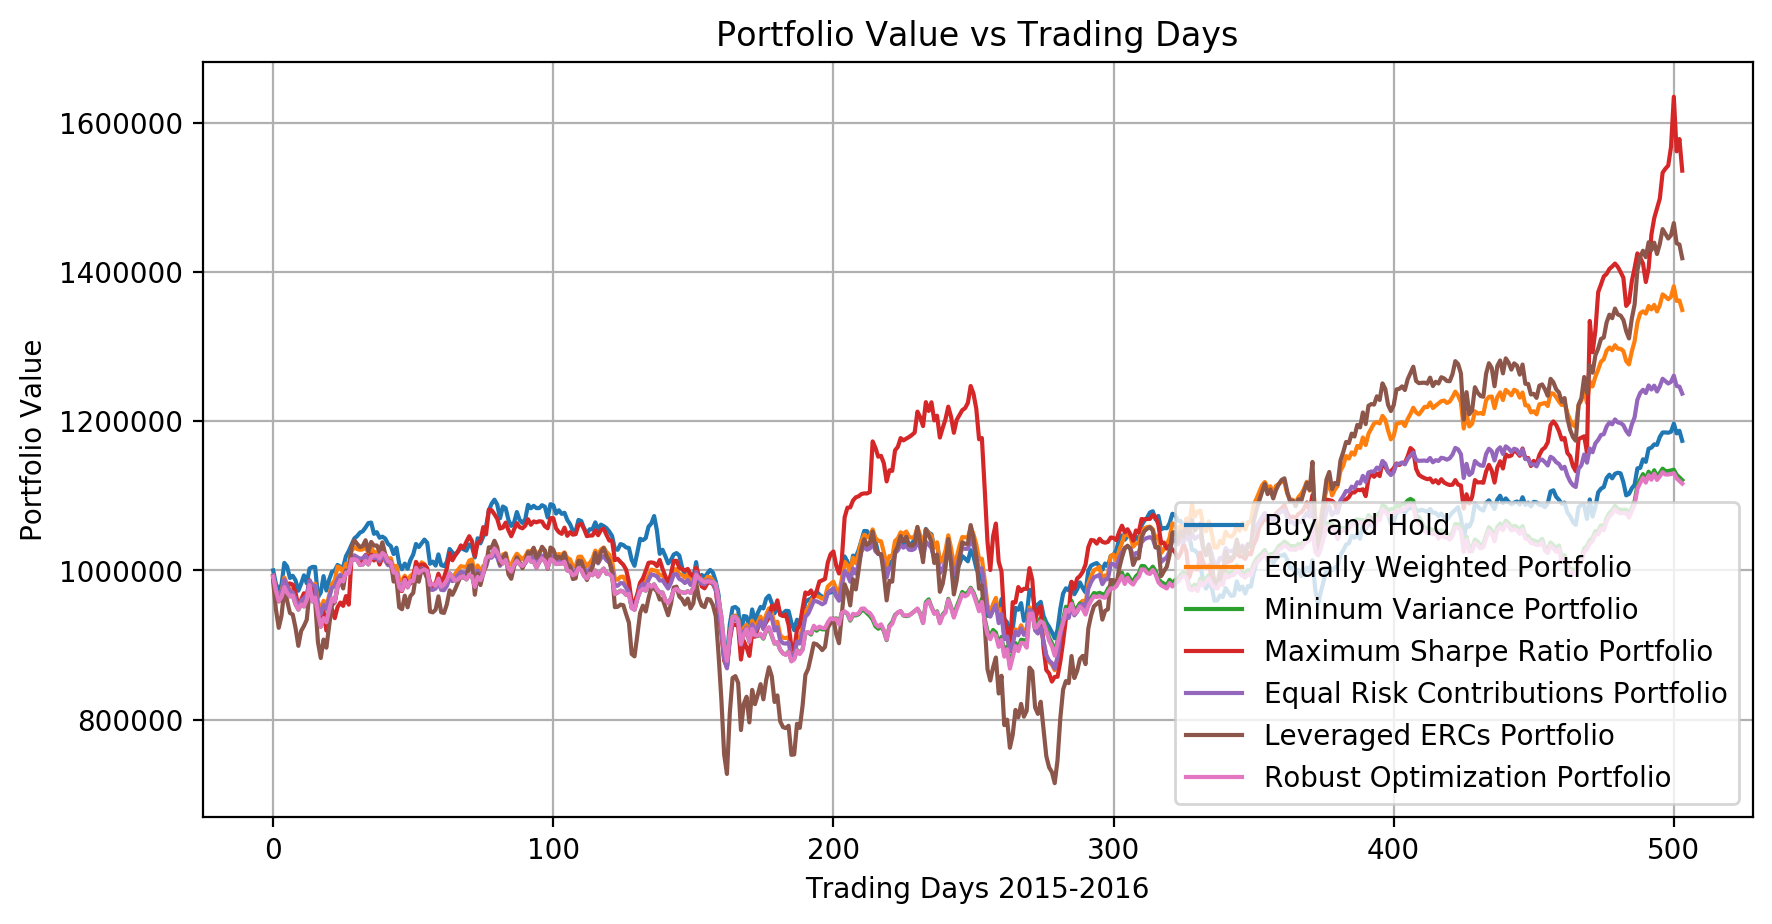

In [48]:
ax2 = plt.gca()
#plt.rcParams['figure.figsize'] = [20, 5]
#plt.rcParams['figure.dpi'] = 200
for n  in range(N_strat):
    ax2.plot(d, a[n], label=strategy_names[n])

ax2.set_xlabel('Trading Days 2015-2016')
ax2.set_ylabel('Portfolio Value')
plt.title('Portfolio Value vs Trading Days')
ax2.legend(loc="lower right")
ax2.grid()
plt.show()

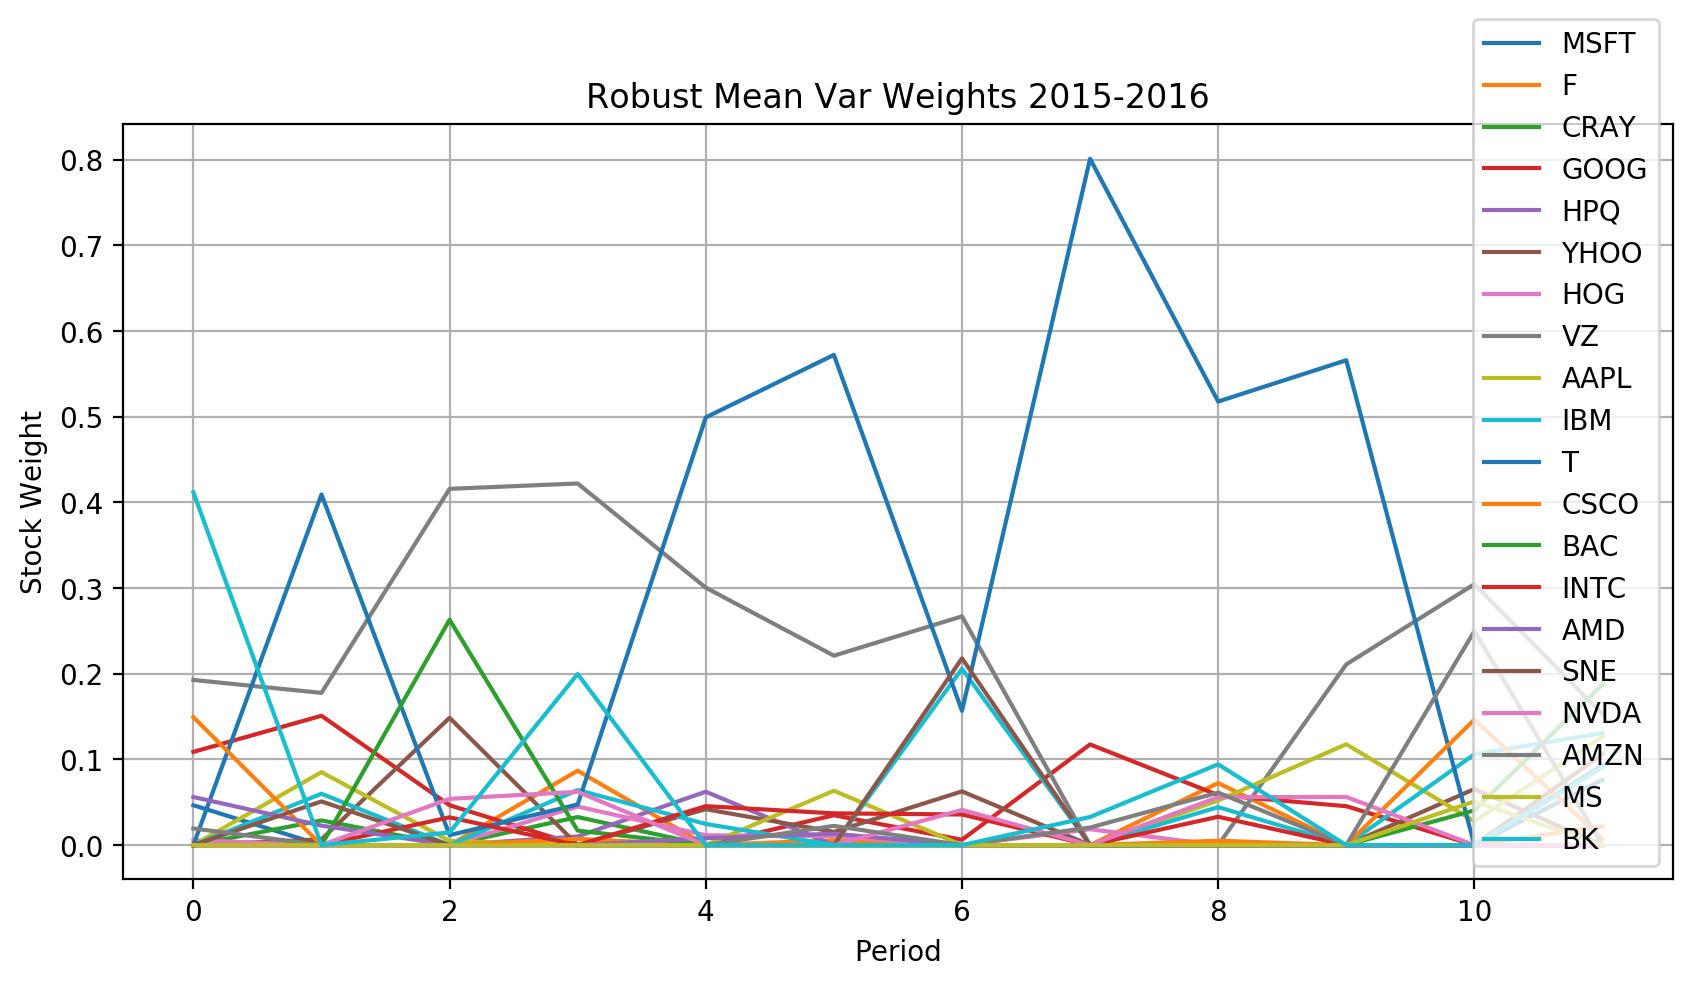

In [49]:
ax2 = plt.gca()
#plt.rcParams['figure.figsize'] = [10, 5]
#plt.rcParams['figure.dpi'] = 200

for i in range(20):   
    ax2.plot(list(range(12)), df_robvarweights[i], label=df.columns[i+1],)

ax2.set_xlabel('Period')
ax2.set_ylabel('Stock Weight')
plt.title('Robust Mean Var Weights 2015-2016')
ax2.legend(loc="lower right")
ax2.grid()
plt.show()

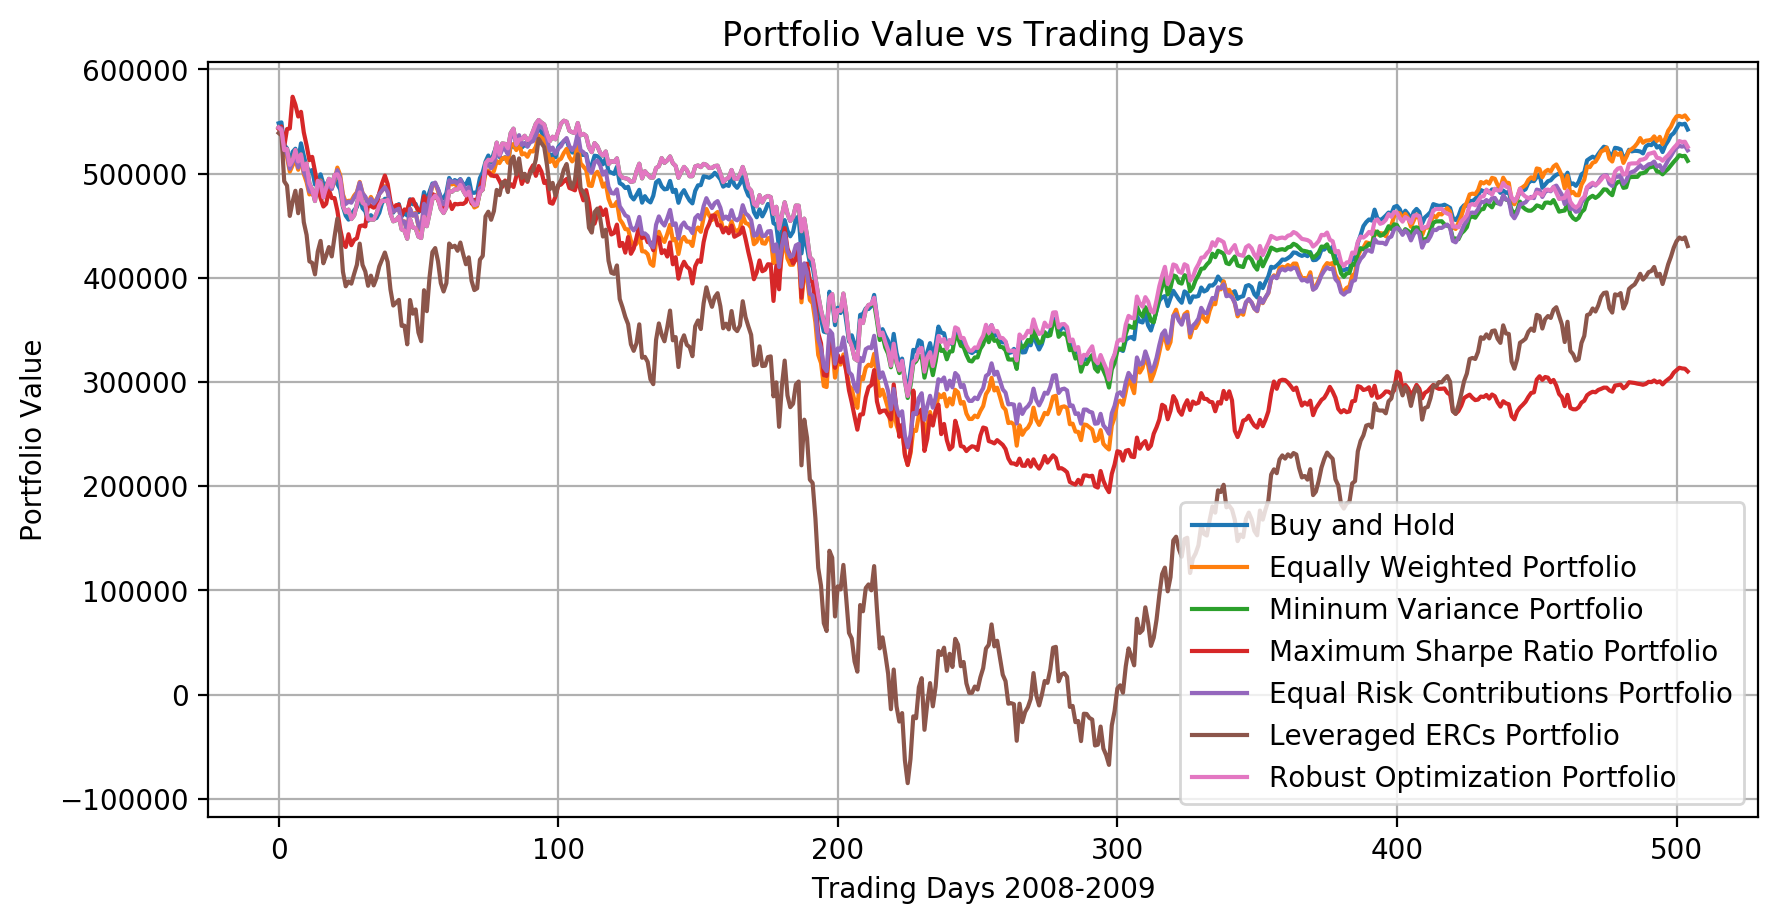

In [50]:
ax2 = plt.gca()
#plt.rcParams['figure.figsize'] = [20, 5]
#plt.rcParams['figure.dpi'] = 200
for n  in range(N_strat):
    ax2.plot(list(range(len(dates))), portf_value[n], label=strategy_names[n])

ax2.set_xlabel('Trading Days 2008-2009')
ax2.set_ylabel('Portfolio Value')
plt.title('Portfolio Value vs Trading Days')
ax2.legend(loc="lower right")
ax2.grid()
plt.show()

In [42]:
df_robvarweights2008 = pd.DataFrame()
for i in range(20):
    for j in range(12):
        df_robvarweights2008 = df_robvarweights2008.append({i: (weights[6][j][i])}, ignore_index = True)
df_robvarweights2008= df_robvarweights2008.apply(lambda x: pd.Series(x.dropna().values))
df_robvarweights2008 = df_robvarweights2008.apply(lambda x: pd.Series(x.dropna().values)).fillna('')

In [43]:
df_minvarweights2008 = pd.DataFrame()
for i in range(20):
    for j in range(12):
        df_minvarweights2008 = df_minvarweights2008.append({i: (weights[2][j][i])}, ignore_index = True)
df_minvarweights2008= df_minvarweights2008.apply(lambda x: pd.Series(x.dropna().values))
df_minvarweights2008 = df_minvarweights2008.apply(lambda x: pd.Series(x.dropna().values)).fillna('')

In [44]:
df_maxsharweights = pd.DataFrame()
for i in range(20):
    for j in range(12):
        df_maxsharweights = df_maxsharweights.append({i: (weights[3][j][i])}, ignore_index = True)
df_maxsharweights= df_maxsharweights.apply(lambda x: pd.Series(x.dropna().values))
df_maxsharweights = df_maxsharweights.apply(lambda x: pd.Series(x.dropna().values)).fillna('')

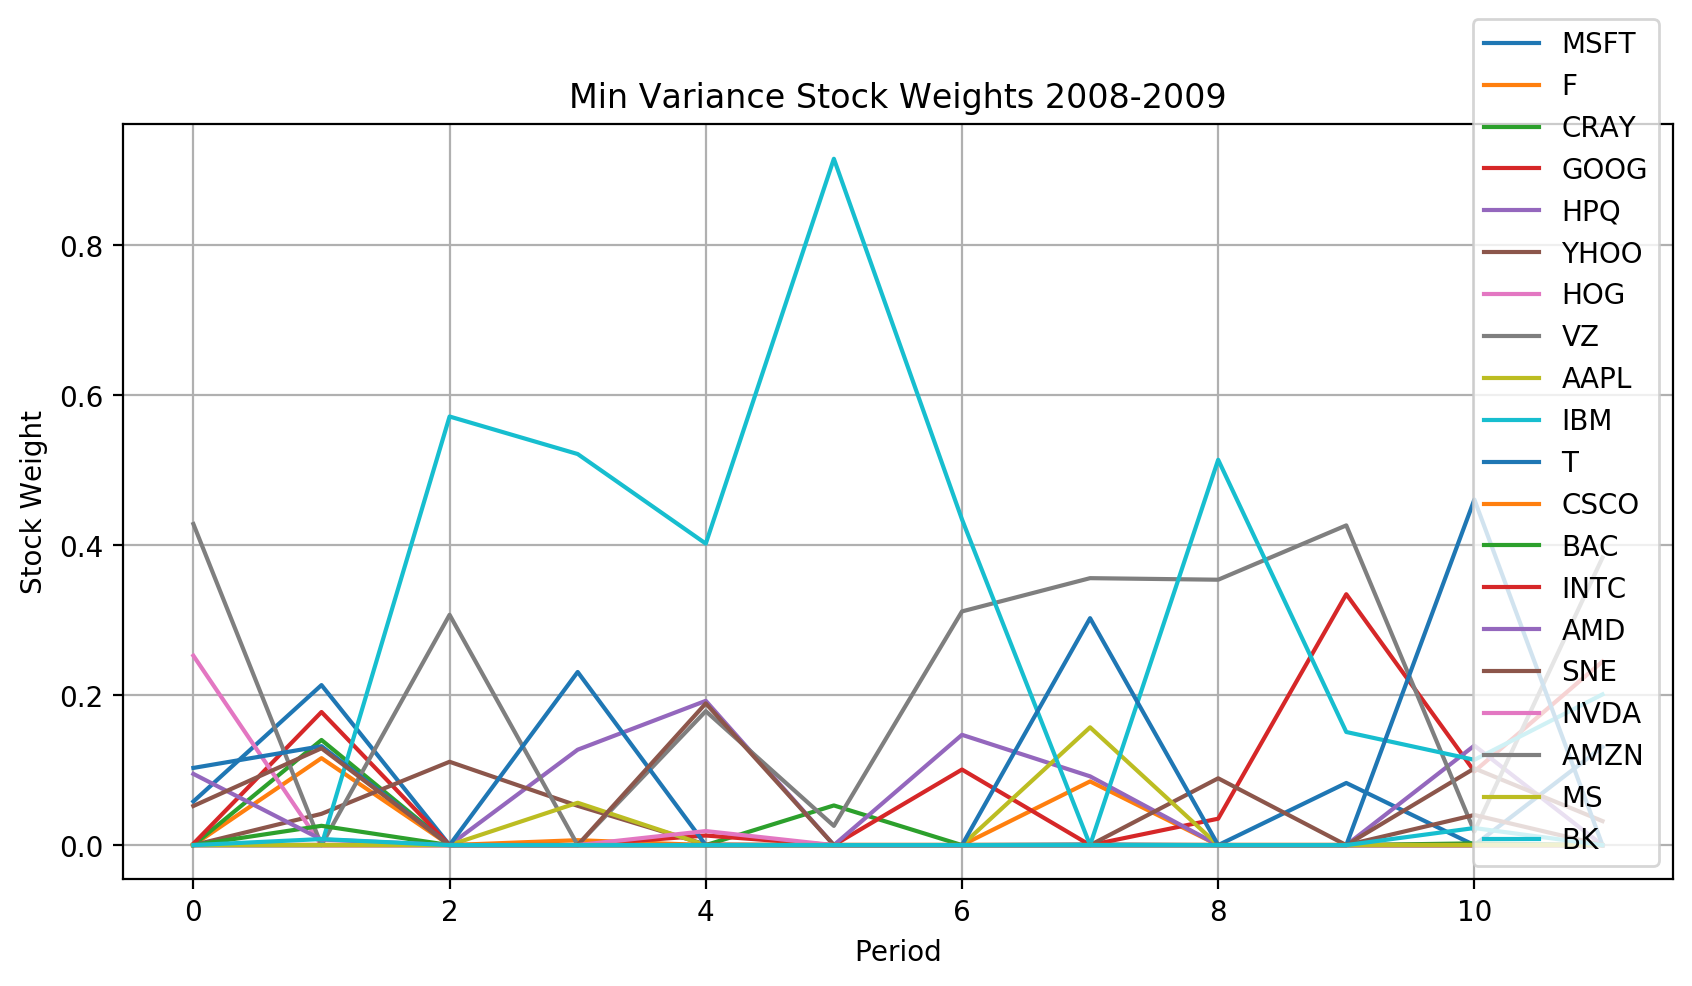

In [51]:
ax2 = plt.gca()
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200

for i in range(20):   
    ax2.plot(list(range(12)), df_minvarweights2008[i], label=df.columns[i+1],)

ax2.set_xlabel('Period')
ax2.set_ylabel('Stock Weight')
plt.title('Min Variance Stock Weights 2008-2009')
ax2.legend(loc="lower right")
ax2.grid()
plt.show()

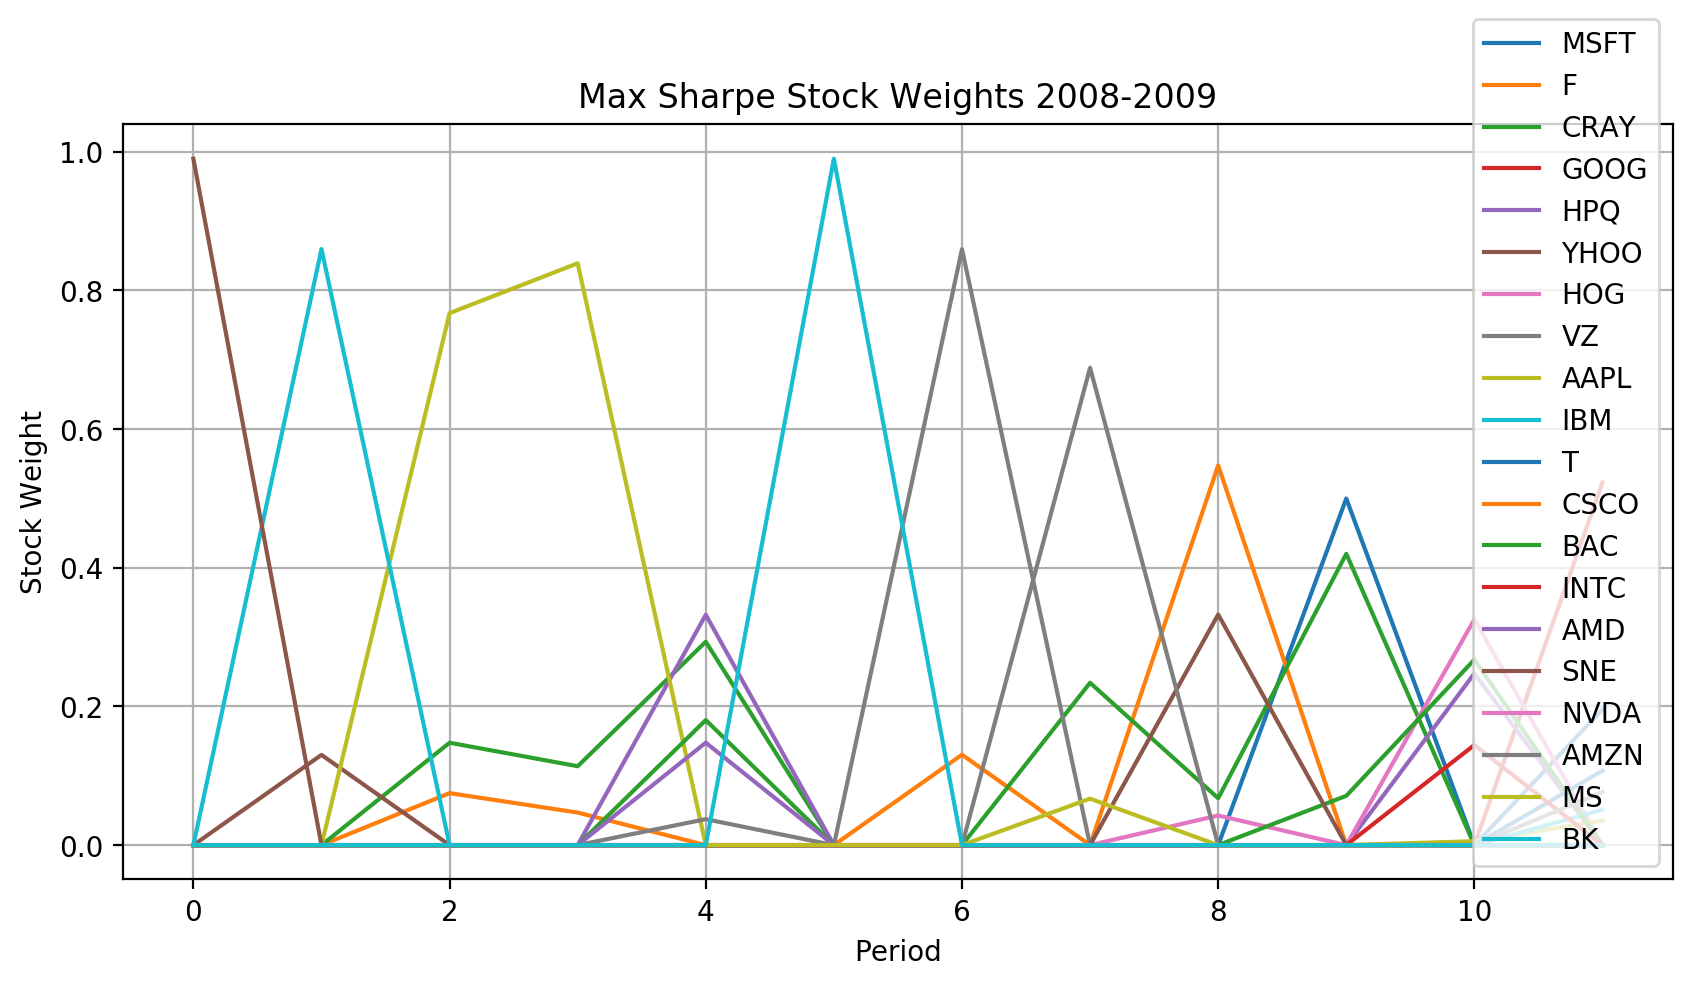

In [46]:
ax2 = plt.gca()
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200

for i in range(20):   
    ax2.plot(list(range(12)), df_maxsharweights[i], label=df.columns[i+1],)

ax2.set_xlabel('Period')
ax2.set_ylabel('Stock Weight')
plt.title('Max Sharpe Stock Weights 2008-2009')
ax2.legend(loc="lower right")
ax2.grid()
plt.show()

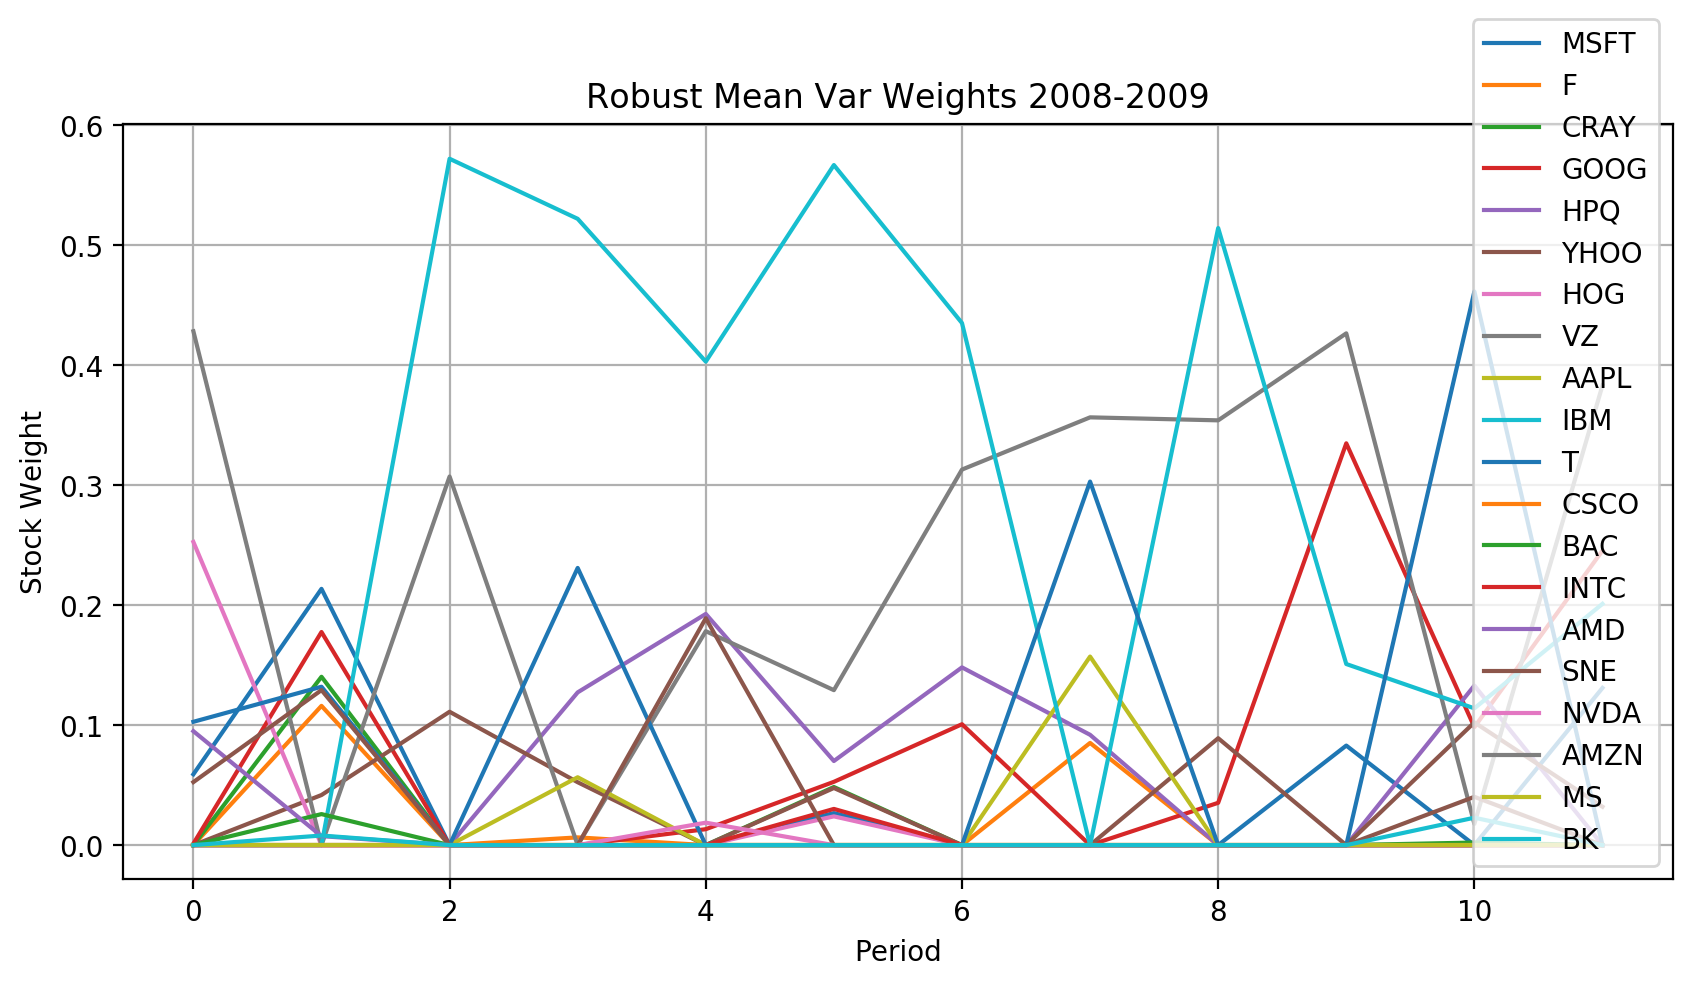

In [47]:
ax2 = plt.gca()
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200

for i in range(20):   
    ax2.plot(list(range(12)), df_robvarweights2008[i], label=df.columns[i+1],)

ax2.set_xlabel('Period')
ax2.set_ylabel('Stock Weight')
plt.title('Robust Mean Var Weights 2008-2009')
ax2.legend(loc="lower right")
ax2.grid()
plt.show()